Navigation to working directory

In [1]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/MyDrive/Colab Notebooks"

Mounted at /content/drive
beach.jpg			       mountainEdge.jpg
cherryBlossom.jpg		       mountain.jpg
cloud.jpg			       munnar.mp4
clouds.jpg			       out
CreativeDeepDream.ipynb		       plateau.jpg
DeepDreamArt.ipynb		       tensorflow_inception_graph.pb
DeepDream_IV.ipynb		       test.mp4
flowers.jpg			       Untitled2.ipynb
imagenet_comp_graph_label_strings.txt  view2.jpg
inception5h.zip			       View.jpg
LICENSE				       wheel.jpeg
mountain2.jpg


Setting Tensorflow version 1

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### **Part 1: DEEP DREAM ON IMAGES**

In [3]:
#Importing the required Libraries

#For Numerical Operations
import numpy as np
from functools import partial
#Loading Images
import PIL.Image
# Tensorflow for loading models
import tensorflow as tf
#For Plots
import matplotlib.pyplot as plt
import urllib.request
import os
#For Zip Operations
import zipfile

In [4]:
#1) Downloading pre-trained neural network from Google API's
url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'

# Directory to download the data to.
data_directory = '/content/drive/MyDrive/Colab Notebooks/'
model_name = os.path.split(url)[-1]
#Zip File
file_path_zip = os.path.join(data_directory, model_name)

In [5]:
#Extracting the ZIP File
if not os.path.exists(file_path_zip):
    # Download
    model_url = urllib.request.urlopen(url)
    with open(file_path_zip, 'wb') as output:
        output.write(model_url.read())
    # Extract
    with zipfile.ZipFile(file_path_zip, 'r') as zip_ref:
        zip_ref.extractall(data_directory)

In [6]:
#Reading the inception model fle
model_pbGraph = 'tensorflow_inception_graph.pb'

In [7]:
# start with a gray image with adding a little noise
noisy_image = np.random.uniform(size=(224,224,3)) + 100.0

In [8]:
#2) Creating Tensorflow session and loading the model which we downloaded!
graph = tf.Graph()
# TF Session
sess = tf.InteractiveSession(graph=graph)

In [9]:
#Iterating over gfile in data directory
with tf.gfile.FastGFile(os.path.join(data_directory, model_pbGraph), 'rb') as f:
    def_graph = tf.GraphDef()
    def_graph.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor

Instructions for updating:
Use tf.gfile.GFile.


In [10]:
#Setting Mean
mean_ImageNet = 117.0

In [11]:
#Pre Processing Step
preprocessed_tf = tf.expand_dims(t_input-mean_ImageNet, 0)
tf.import_graph_def(def_graph, {'input':preprocessed_tf})

no_layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
no_of_features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in no_layers]

In [12]:
#Printing Number of layers
print('Total Number of layers', len(no_layers))
print('Total number of feature channels:', sum(no_of_features))

Total Number of layers 59
Total number of feature channels: 7548


In [13]:
#Function to show the array as image  
def showImageFromArray(a):
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a)
    plt.show()

In [14]:
#Function for getting layer output tensor
def T(layer):
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [15]:
#Function that transforms TF-graph generating function into a regular one.
def tensor_function(*argtypes):
    holdingPlace = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*holdingPlace)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(holdingPlace, args)), session=kw.get('session'))
        return wrapper
    return wrap

In [16]:
#Function to resize the image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

In [17]:
#Resizing!
resize = tensor_function(np.float32, np.int32)(resize)

In [18]:
#Function toCompute the value of tensor t_grad over the image in a tiled way.
def calculate_tiled_gradient(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0) 

In [19]:
#Function for rendering frames 
def render_creativedeepdream(t_obj, img0=noisy_image,
                      iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective!
    t_grad = tf.gradients(t_score, t_input)[0] # beholding the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calculate_tiled_gradient(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
        
        #Usually we have like 3 or 4 octaves
        #SHowing output deep dream image using matplotlib
        showImageFromArray(img/255.0)


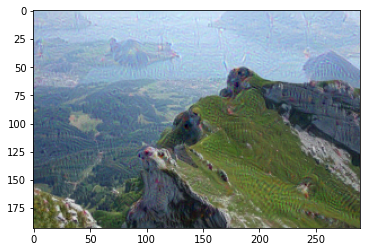

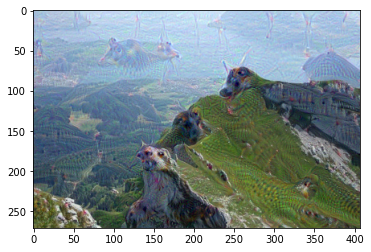

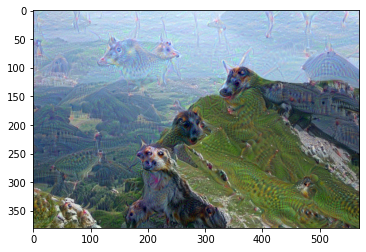

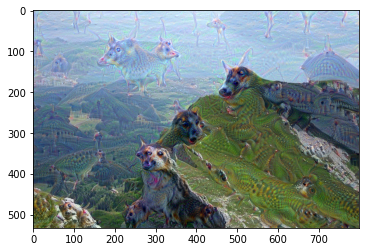

In [20]:
######################################################################################################
#Image Deep Dream Part!!!
#Step 3 - Pick a layer to enhance our image
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

#open image
img0 = PIL.Image.open('/content/drive/MyDrive/Colab Notebooks/plateau.jpg')
img0 = np.float32(img0)
  
#Step 4 - Apply gradient ascent to that layer
render_creativedeepdream(tf.square(T('mixed4c')), img0)
##########################################################################################################

### PART 2 : DEEP DREAM ON VIDEOS 

In [21]:
pip install numpngw #Installing required Library

In [22]:
#Requied Libraris for Video
from numpngw import write_png
import imageio

In [23]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

In [24]:
#Loading Model 
model_fn = 'tensorflow_inception_graph.pb'

In [25]:
#Creating Another Tensorflow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(os.path.join(data_directory, model_fn), 'rb') as f:
    def_graph = tf.GraphDef()
    def_graph.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
mean_ImageNet = 117.0

/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [26]:
#Preprocessing of model
preprocessed_tf = tf.expand_dims(t_input-mean_ImageNet, 0)
tf.import_graph_def(def_graph, {'input':preprocessed_tf})

In [27]:
#no of layers in model used
no_layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
no_of_features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in no_layers]

print('Total Number of Layers', len(no_layers))
for i in no_layers:
    print(i)
print('Total number of feature channels:', sum(no_of_features))

Total Number of Layers 59
import/conv2d0_pre_relu/conv
import/conv2d1_pre_relu/conv
import/conv2d2_pre_relu/conv
import/mixed3a_1x1_pre_relu/conv
import/mixed3a_3x3_bottleneck_pre_relu/conv
import/mixed3a_3x3_pre_relu/conv
import/mixed3a_5x5_bottleneck_pre_relu/conv
import/mixed3a_5x5_pre_relu/conv
import/mixed3a_pool_reduce_pre_relu/conv
import/mixed3b_1x1_pre_relu/conv
import/mixed3b_3x3_bottleneck_pre_relu/conv
import/mixed3b_3x3_pre_relu/conv
import/mixed3b_5x5_bottleneck_pre_relu/conv
import/mixed3b_5x5_pre_relu/conv
import/mixed3b_pool_reduce_pre_relu/conv
import/mixed4a_1x1_pre_relu/conv
import/mixed4a_3x3_bottleneck_pre_relu/conv
import/mixed4a_3x3_pre_relu/conv
import/mixed4a_5x5_bottleneck_pre_relu/conv
import/mixed4a_5x5_pre_relu/conv
import/mixed4a_pool_reduce_pre_relu/conv
import/mixed4b_1x1_pre_relu/conv
import/mixed4b_3x3_bottleneck_pre_relu/conv
import/mixed4b_3x3_pre_relu/conv
import/mixed4b_5x5_bottleneck_pre_relu/conv
import/mixed4b_5x5_pre_relu/conv
import/mixed4b_p

In [28]:
# Helper functions for TF Graph visualization

def strip_consts(def_graph, max_const_size=32):
    """Strip large constant values from def_graph."""
    strip_def = tf.GraphDef()
    for n0 in def_graph.node:
        n = strip_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

In [29]:
#Function to rename nodes
def rename_nodes(def_graph, rename_func):
    res_def = tf.GraphDef()
    for n0 in def_graph.node:
        n = res_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  

In [30]:
# '''Normalize the image range for visualization'''
def visstd(a, s=0.1):
   
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

In [31]:
#'''Helper for getting layer output tensor'''
def T(layer):
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [32]:
#Optimization
def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for _ in range(iter_n):
        g, _ = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different no_layers and networks
        img += g*step
    showImageFromArray(visstd(img))
    

In [33]:
# '''Helper that transforms TF-graph generating function into a regular one.

def tensor_function(*argtypes):

    holdingPlace = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*holdingPlace)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(holdingPlace, args)), session=kw.get('session'))
        return wrapper
    return wrap


In [34]:
#Resize Images
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tensor_function(np.float32, np.int32)(resize)

In [35]:
# '''Compute the value of tensor t_grad over the image in a tiled way.
#   Random shifts are applied to the image to blur tile boundaries over 
#   multiple iterations.'''
def calculate_tiled_gradient(img, t_grad, tile_size=512):
  
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)    


In [36]:
#Saving Images fromarray
def saveImageFromArray(a, i):
    a = np.uint8(np.clip(a, 0, 1)*255)
    write_png('/content/drive/MyDrive/Colab Notebooks/out/' + str(i) + '.png', a)

In [37]:
#function that outputs a deep dream video
def render_creativedeepdreamvideo(filename):

    #Step 3 - Pick a layer to enhance our image
    layer = 'mixed4d_3x3_bottleneck_pre_relu'
    channel = 139 # picking some feature channel to visualize
    # use ImageIO to read in the video file using ffmpeg
    vid = imageio.get_reader(filename,  'ffmpeg')
    # get individual frames from the video
    enuVid = enumerate(vid)
    # itterate over each frame in the video
    for i, im in enuVid:
        print("Frame : " + str(i))
        img = np.float32(im)

        #Apply gradient ascent to that layer
        creativedeepdreamImg = render_creativedeepdream(T(layer)[:,:,:,channel], img, iter_n=100, octave_n=4, step=1.5, octave_scale=1.4)
        # save the computed image as a png file that will later be stitched together using ffmpeg into a video
        saveImageFromArray(creativedeepdreamImg, i)
    # stitch all frames together into one video
    os.system("ffmpeg -r 30 -f image2 -s 1920x1080 -i /content/drive/MyDrive/Colab Notebooks/out/%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p /content/drive/MyDrive/Colab Notebooks/test.mp4")


In [38]:
def render_creativedeepdream(t_obj, img0=img_noise,
                      iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calculate_tiled_gradient(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
        
        #this will usually be like 3 or 4 octaves
        #Step 5 return deep dream image
        #showImageFromArray(img/255.0)
        return(img/255.0)
        

In [ ]:
#openVideo
filename = '/content/drive/MyDrive/Colab Notebooks/munnar.mp4' #Input any video
render_creativedeepdreamvideo(filename)




Frame : 0
Frame : 1
Frame : 2
Frame : 3
Frame : 4
Frame : 5
Frame : 6
Frame : 7
Frame : 8
